# Synthetic Control (SC)

- 담배값이 오른다고 사람들이 담배 피는 양을 줄일까요, 아니면 중독된 사람들은 가격과 무관하게 피는 양이 유지될까요?
- Proposition 99 라는 법이 캘리포니아에서 통과되었습니다. 이 법은 흡연에 대한 세금을 크게 늘리는 법이었습니다.
- DiD에서처럼 캘리포니아와 사전평행 추세가 있는 주와 비교해도 되겠지만, Synthetic Control은 1:1 비교보다 1:N 비교를 통해 인과 효과를 확인하는 방법을 제안합니다.

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

In [ ]:
cigar = (pd.read_csv("../data/matheus_data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california == True").head() # 캘리포니아는 state == 3에 위치

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


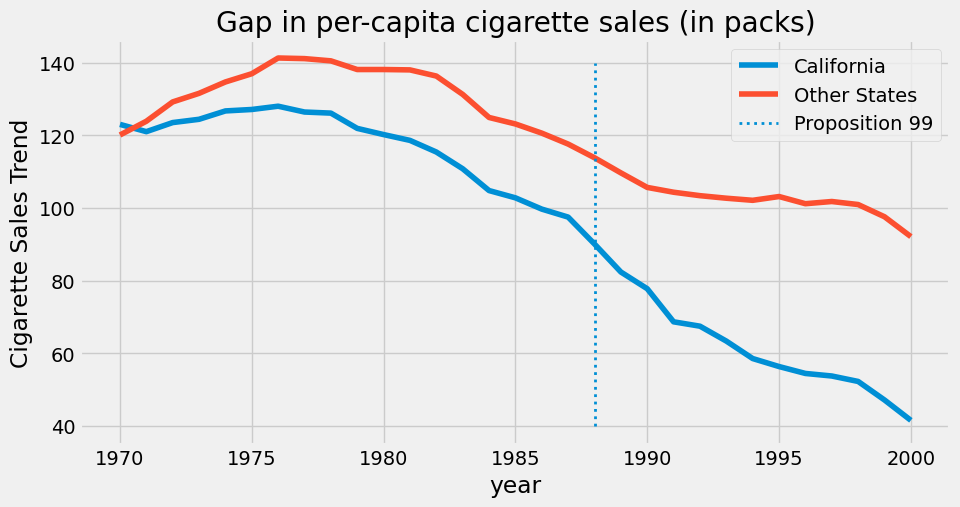

In [12]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot(index="year", columns="california", values="cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();

## 우리의 목표

- 아쉽게도 캘리포니아는 이미 정책 개입을 경험한 처리 집단이기에 정책의 효과를 온전하게 반영하지 못 하고 있습니다. (즉, 캘리포니아의 사후 관측치는 단순히 자연적인 추세만을 반영하는 것이 아니라, 정책 효과가 혼합되어 나타난 결과로 이해됩니다.)

- 이를 해결하기 위해 우선 캘리포니아와 유사한 개입 이전 추세를 재현할 수 있는 가상의 대조 집단(합성 통제군)을 구성합니다.

- 이를 통해 개입 이후 시점에서 실제 캘리포니아와 합성 통제군 간의 차이를 정책 효과로 식별하면 그것이 정책의 효과를 표현하게 됩니다.



### 1. 기본 원리에 맞게 최적화 (QP)로 구현하기

- STEP 1: 개입 이전 추세의 담배 판매량 추출

- STEP 2: X (처치 이전 나머지 주)를 활용하여 y (처치 이전 캘리포니아) 추정
    - Optimal Weight를 찾아서 y와 비슷하게 구성 (즉, $X W \approx y$)
    - 제약조건: weight는 음수가 불가하며, 합은 1이 되도록 지정. 

- STEP 3: 가중치 기반으로 Estimate 생성

In [49]:
# STEP 0: Synthetic Control에 맞는 Loss function 및 Optimization 정의

from scipy.optimize import fmin_slsqp
from toolz import partial

def loss_w(W, X, y): # RMSE
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y): # Sequential Least-Squares Quadratic Programming
    w_start = [1/X.shape[1]]*X.shape[1] # inital value

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1, # weights to sum up to 1
                         bounds=[(0.0, 1.0)]*len(w_start), # 0~1
                         disp=False)
    return weights

In [50]:
# STEP 1: 개입 이전 추세의 담배 판매량 추출

inverted = (cigar.query("~after_treatment")
            .pivot(index='state', columns="year")["cigsale"]
            .T)

inverted.head()

state,1,2,3,...,37,38,39
year,,,,,,,
1970,89.800003,100.300003,123.000000,...,114.500000,106.400002,132.199997
1971,95.400002,104.099998,121.000000,...,111.500000,105.400002,131.699997
1972,101.099998,103.900002,123.500000,...,117.500000,108.800003,140.000000
1973,102.900002,108.000000,124.400002,...,116.599998,109.500000,141.199997
1974,108.199997,109.699997,126.699997,...,119.900002,111.800003,145.800003


In [51]:
y = inverted[3].values # 우리가 관심 있는 주
X = inverted.drop(columns=3).values  # 통제집단을 위한 나머지 주

print(y.shape, X.shape)

(19,) (19, 38)


In [52]:
# STEP 2: X (처치 이전 나머지 주) -> y (처치 이전 캘리포니아) 추정

calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.0000000000013631


array([0.    , 0.    , 0.0148, 0.1091, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.2318, 0.    , 0.2049, 0.0454, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.3939, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [53]:
# STEP 3: 가중치 기반으로 Estimate 생성

calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

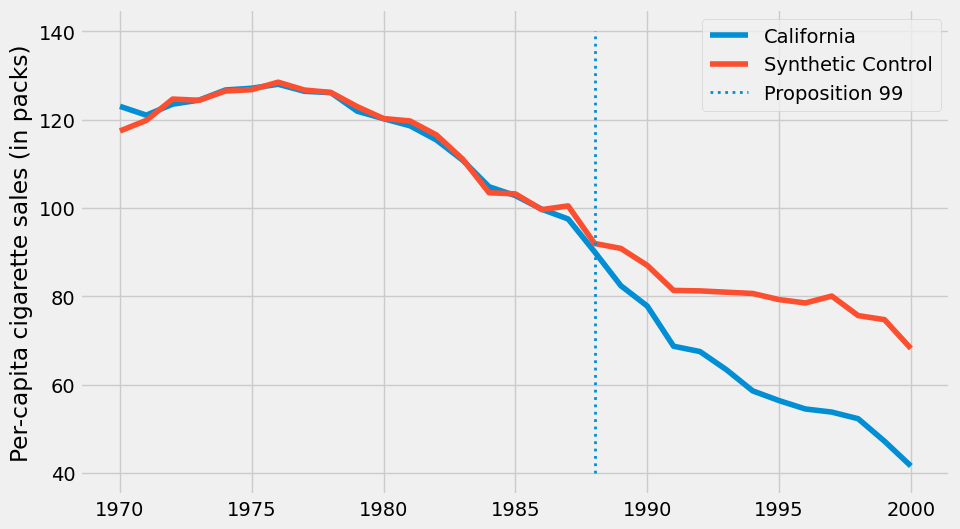

In [54]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

- 현재는 소수 donor 주에 weight가 몰려 있음.
- 즉, 추가적인 검정이 필요.
- 추가하고 싶은 내용:
    - Regularization을 추가한다면?
    - 추론 (신뢰구간) 까지 같이 필요하다면?

### 2. 패키지 활용하기

- [Dependencies] (의존성 체크 필요)
    - cvxpy (>= 1.1.18)
    - dask (>= 2021.04.0)
    - ecos (>= 2.0.7)
    - luddite (>= 1.0.2)
    - numpy (>= 1.20.1)
    - pandas (>= 1.5.0)
    - plotnine (>= 0.8.0)
    - scikit-learn (>= 0.24.1)
    - scipy (>= 1.7.1)
    - statsmodels (>= 0.12.2)

- 가상환경 설정
```bash
conda install -c conda-forge "numpy>=1.20.1" "pandas>=1.5.0" "scikit-learn>=0.24.1" "scipy<1.11" "statsmodels>=0.12.2"
pip install "scpi-pkg" "dask>=2021.04.0" "ecos>=2.0.7" "luddite>=1.0.2" "plotnine>=0.8.0" "cvxpy>=1.1.18"
```


- STEP 1: 데이터 준비

```python
data_prep = scdata(
    df=data,
    id_var="state",            # 단위 식별자
    time_var="year",           # 시간 변수
    outcome_var="cigsale",     # 결과 변수 (담배 판매량)
    period_pre=period_pre,     # 개입 이전 기간
    period_post=period_post,   # 개입 이후 기간
    unit_tr=unit_tr,           # 처리 집단 (예: California)
    unit_co=unit_co,           # donor pool (나머지 주들)
    constant=True,
    cointegrated_data=True,
    features= features         # 공변량     
    cov_adj=...
)
```


- STEP 2: 데이터 추정

```python
est.si = scest(data.prep, w_constr={'name':'simplex'})
print(est.si)
```

- STEP 3: 추론 및 시각화

```python
pi.si = scpi(
    data.prep,
    sims=sims,
    w_constr={'name': mtd},
    ...
)
plot = scplot(pi.si, x_lab='Year', y_lab='GDP per capita...')
```

In [37]:
!pip install scpi_pkg

In [38]:
from scpi_pkg.scdata import scdata
from scpi_pkg.scdataMulti import scdataMulti
from scpi_pkg.scest import scest
from scpi_pkg.scpi import scpi
from scpi_pkg.scplot import scplot
from scpi_pkg.scplotMulti import scplotMulti

In [ ]:
# 데이터 준비, 이번에는 공변량까지 사용
cigar.head()

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False


#### 2-1. 직접 구현한 내용과 라이브러리 비교

In [87]:
# outcome과 feature 지정
outcome_var = "cigsale"
features = ["cigsale", "retprice"]

# 기간 지정
period_pre = np.arange(1970, 1988)
period_post = np.arange(1988, 2000)

# 처리집단/대조군 지정
unit_tr = int(cigar.loc[cigar["california"], "state"].unique()[0])
unit_co = cigar.loc[~cigar["california"], "state"].unique().tolist()

# 데이터 준비
data_prep = scdata(
    df=cigar,
    id_var="state",
    time_var="year",
    outcome_var=outcome_var,
    period_pre=period_pre,
    period_post=period_post,
    unit_tr=unit_tr,
    unit_co=unit_co,
    features=features
)

# 합성통제 추정
est = scest(data_prep, w_constr={'name':'simplex'})
print(est)

# 추론 + 플롯
pi = scpi(data_prep, sims=1000, w_constr={'name':'simplex'})
plot_simplex = scplot(pi, x_lab="Year", y_lab="Cigarette sales (packs per capita)")

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                                simplex
Constraint Size (Q):                                                  1
Treated Unit:                                                         3
Size of the donor pool:                                              38
Features                                                              2
Pre-treatment period                                          1970-1987
Pre-treatment periods used in estimation per feature:
 Feature  Observations
 cigsale            18
retprice            18
Covariates used for adjustment per feature:
 Feature  Num of Covariates
 cigsale                  0
retprice                  0

Synthetic Control Estimation - Results

Active donors: 6

Coefficients:
                    Weights
Treated Unit Donor         
3            1       -0.000
             10       0.000
          

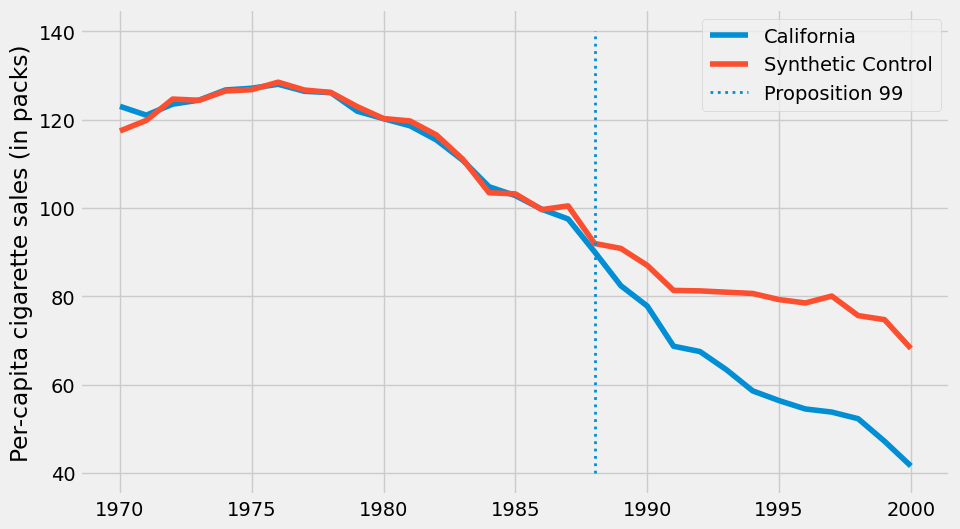

In [85]:
# 이전 결과와 비교

plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

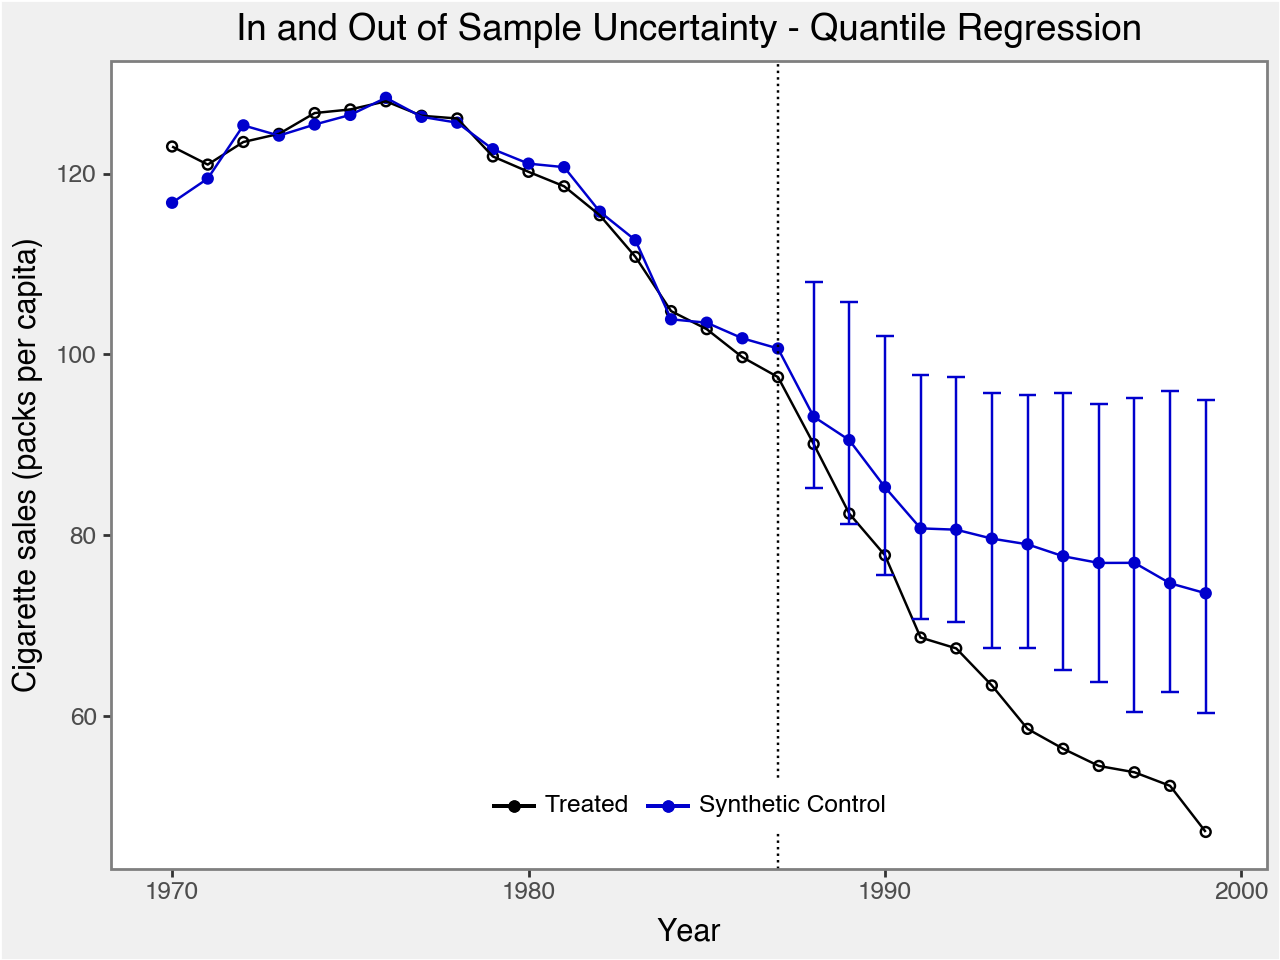

In [88]:
plot_simplex

#### 2-2. Simplex, Ridge, Lasso

In [ ]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cigar[['cigsale','retprice']] = scaler.fit_transform(cigar[['cigsale','retprice']])

In [94]:
methods = ['simplex', 'lasso', 'ridge']
results = {}
plots = []

# 동일한 옵션
sims = 1000
u_order = 1
u_lags = 0
e_order = 1
e_lags = 0
u_missp = True
u_sigma = 'HC1'
e_method = 'gaussian'
cores = 1

data_prep = scdata(
    df=cigar,
    id_var="state",
    time_var="year",
    outcome_var="cigsale",
    period_pre=np.arange(1970, 1988),
    period_post=np.arange(1988, 2000),
    unit_tr=unit_tr,
    unit_co=unit_co,
    features=["cigsale","retprice"]
)


for mtd in methods:
    print(f"Running method: {mtd}")
    pi_mtd = scpi(
        data_prep,
        sims=sims,
        w_constr={'name': mtd, 'Q': 1},
        u_order=u_order,
        u_lags=u_lags,
        e_order=e_order,
        e_lags=e_lags,
        e_method=e_method,
        u_missp=u_missp,
        u_sigma=u_sigma,
        cores=cores
    )
    results[mtd] = pi_mtd
    plots.append(scplot(pi_mtd, x_lab="Year", y_lab="Cigarette sales (packs per capita)"))

Running method: simplex
-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)
Running method: lassocompleted (100%)
-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)
 iterations completed (50%)
 iterations completed (60%)
 iterations completed (70%)
 iterations completed (80%)
 iterations completed (90%)
Running method: ridgecompleted (100%)
-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

 iterations completed (10%)
 iterations completed (20%)
 iterations completed (30%)
 iterations completed (40%)

Method: simplex


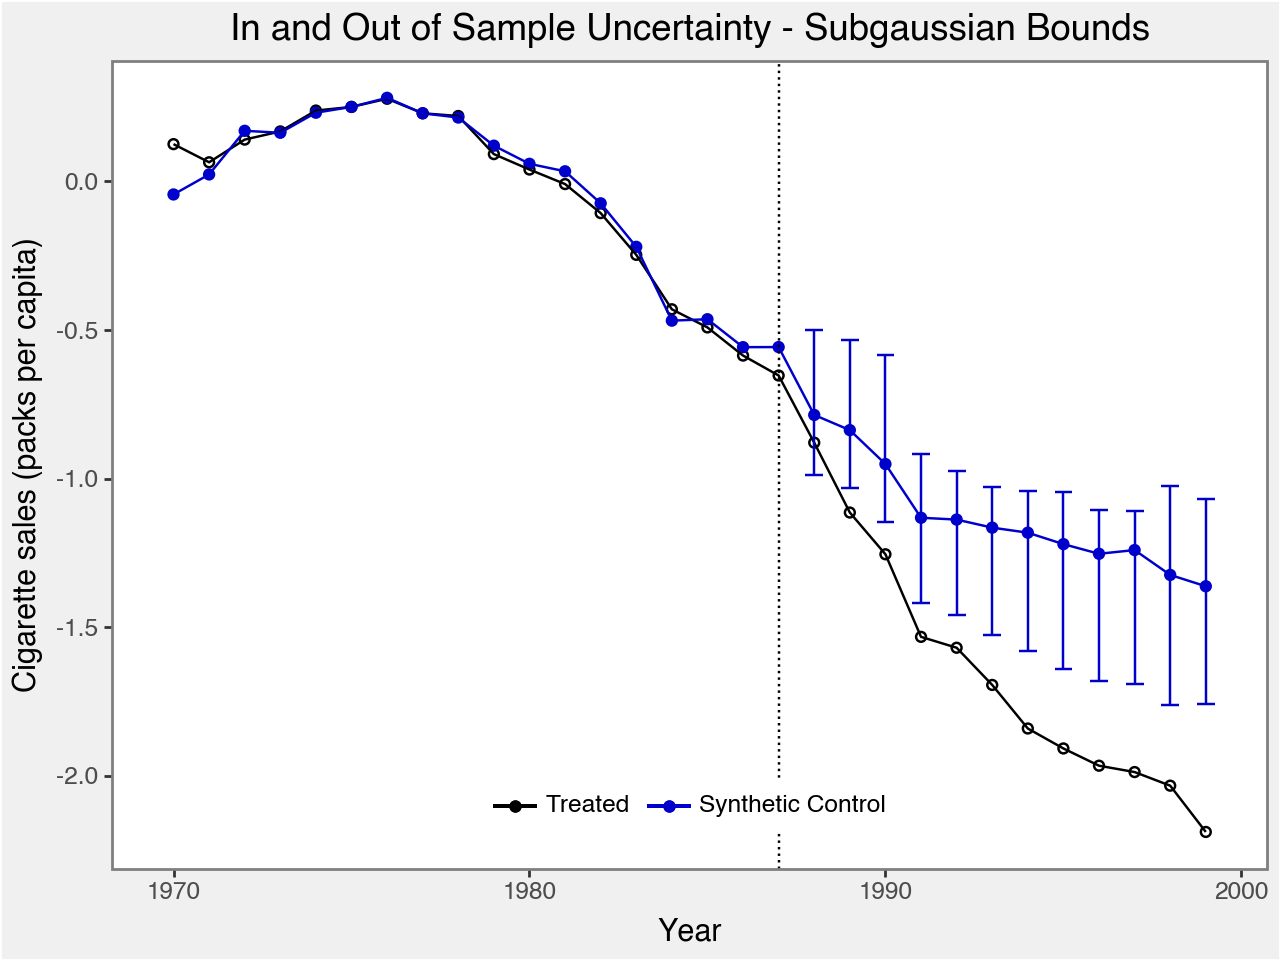

Method: lasso


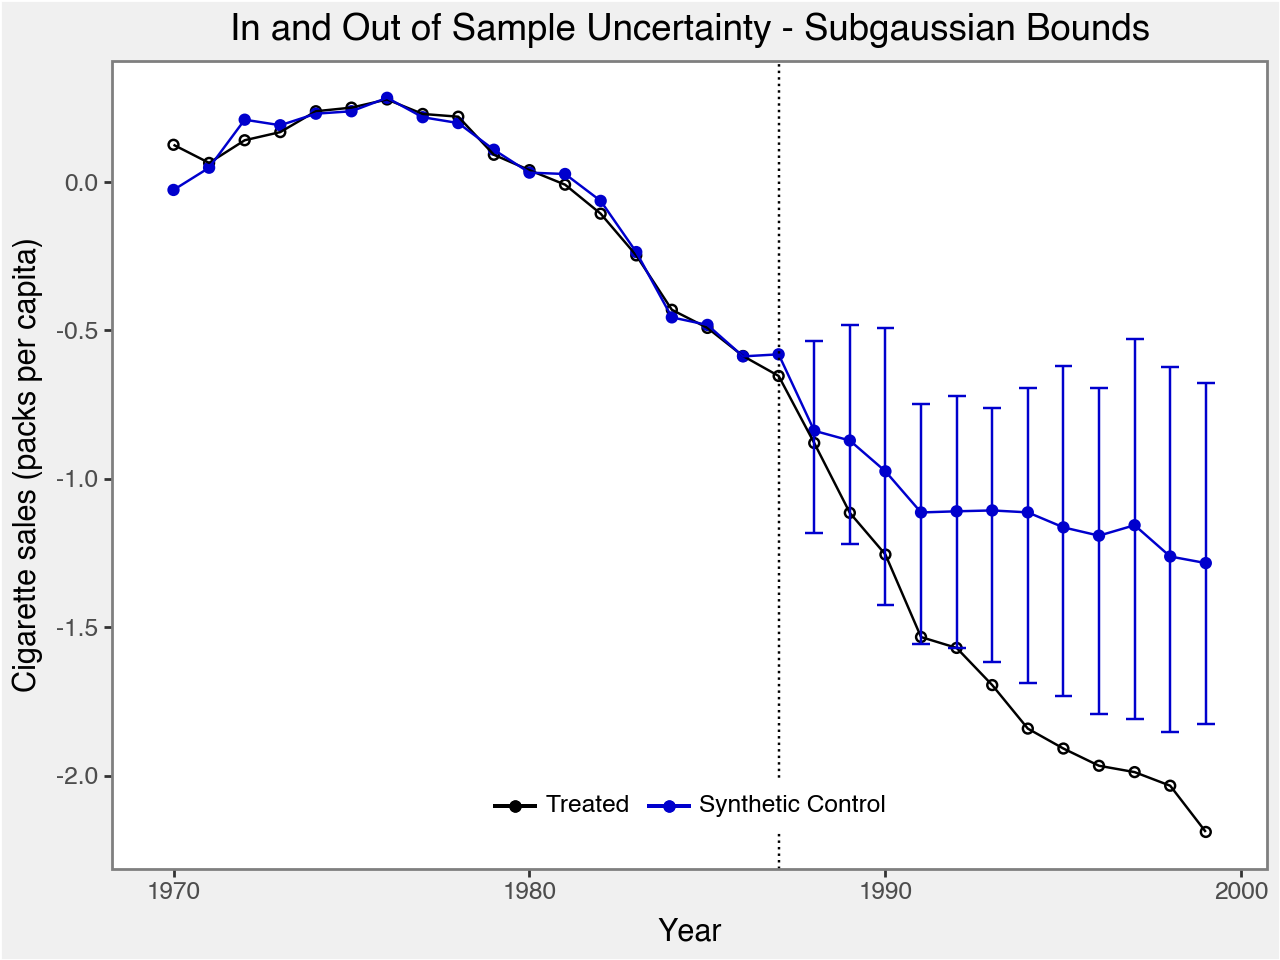

Method: ridge


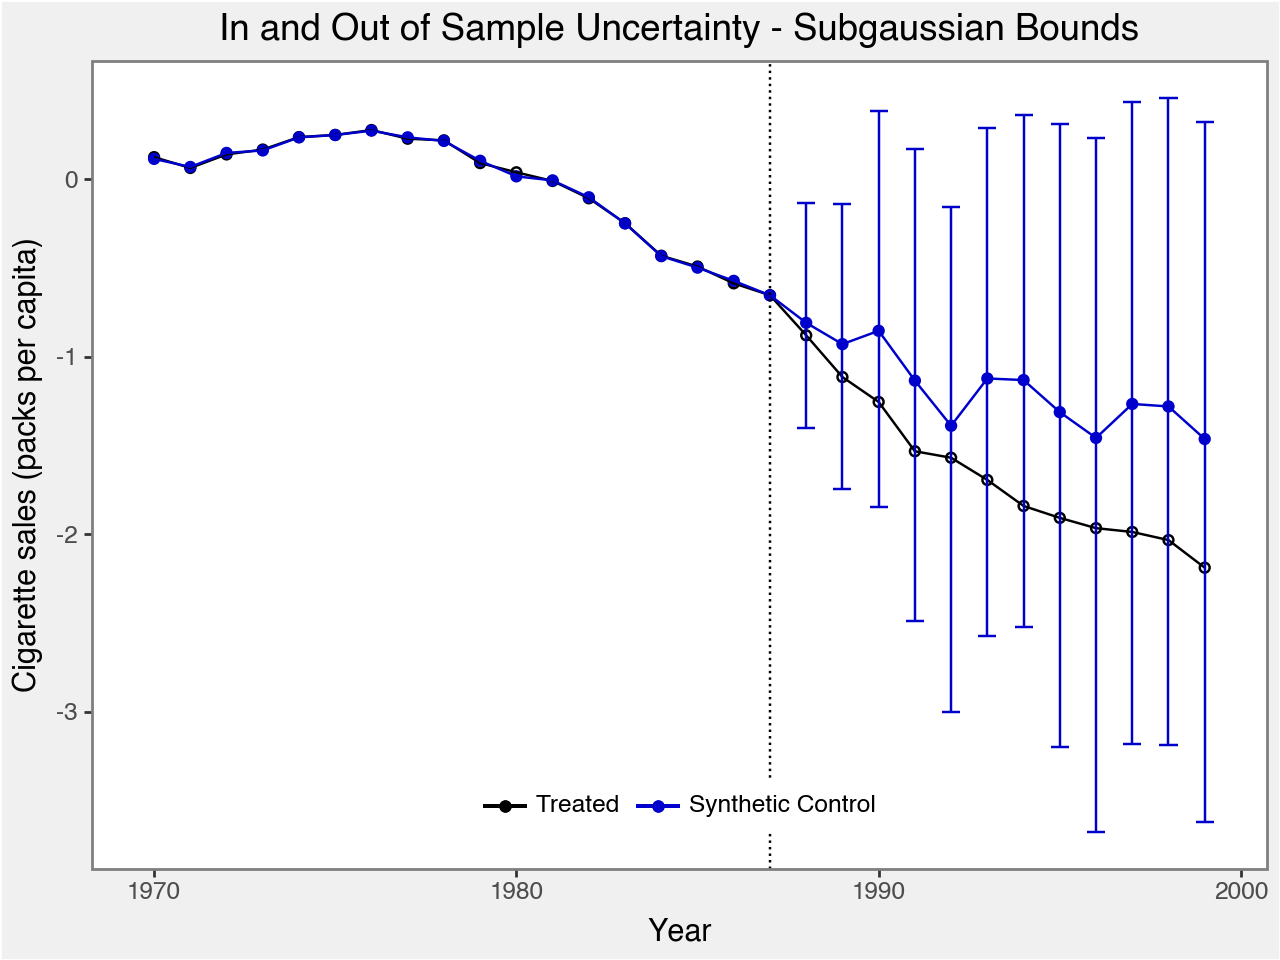

In [100]:
from IPython.display import display

for mtd, p in zip(methods, plots):
    print(f"Method: {mtd}")
    display(p)

** Regularization Method 고르기

현재 결과를 기준으로:

- Simplex: Treated와 Synthetic이 거의 완벽히 일치, 불확실성도 비교적 작은 신뢰성 있는 추정.
- Lasso: 변수 선택 효과로 인해 일부 가중치가 0이 됨. 다만 이 데이터에서 신뢰구간이 다소 커져서 효과 추정의 정밀도는 simplex보다 떨어짐.
- Ridge: 모든 가중치를 조금씩 분산시킴. Treated와 Synthetic이 거의 완벽히 일치, 다만 이 데이터에서 신뢰구간이 더 커져서 효과 추정의 정밀도는 simplex보다 떨어짐.

### 질문이나 의견을 남겨주세요.
<script src="https://utteranc.es/client.js"
        repo="CausalInferenceLab/awesome-causal-inference-python"
        issue-term="pathname"
        theme="github-light"
        crossorigin="anonymous"
        async>
</script>